O algoritmo já feito em matéria anterior foi revisado, alterado e o dataset foi tratado de maneira mais detalhada possível para garantir que os dados refletiriam o que se esperava de resultado. A partir disso aumentamos as épocas de treinamento e obtivemos um resultado muito bom de geração de imagem e acurácia da rede discriminadora.

In [24]:
import os, shutil
import numpy as np 
import pandas as pd 
import cv2

pokemons = 'C:/Users/rafae/OneDrive/Documentos/pokemon/pokemon'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


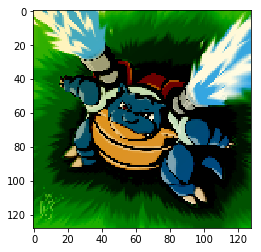

In [25]:
import matplotlib.pyplot as plt
import PIL
from PIL import Image

def convert_to_jpg(img_path):
    img = Image.open(img_path)
    if img.mode == 'RGBA':
        img.load()
        background = Image.new("RGB", img.size, (0,0,0))
        background.paste(img, mask=img.split()[3])
        img = np.array(background)
    else:
        img = img.convert('RGB')
        img = np.array(img)
    
    return img
    img = cv2.resize(img, (128,128))
    return img

def normalize_img(img):
    img = img / 127.5 - 1
    return img

def resize_img(img):
    img = cv2.resize(img, (128,128))
    return img


def open_convert(img_path):
    # png
    if img_path[-4:] == '.png':
        img = convert_to_jpg(img_path)
    # jpeg
    else:
        img = Image.open(img_path)
        img = img.convert('RGB')
        img = np.array(img)

        
    img = resize_img(img)
    img = normalize_img(img)
    
    #Imagem redimencionada para 128x128
    return img

# Test
img = open_convert('C:/Users/rafae/OneDrive/Documentos/pokemon/pokemon/Blastoise/00000001.png')
plt.imshow(img)
plt.show()

Os diretórios e imagens foram tratados, com intuito de restar apenas imagens que, de fato, são pokemons. Sendo assim diminuimos o range de diretórios e aumentamos o poder do algoritmo

In [26]:
os.listdir(pokemons)

dirs = os.listdir(pokemons)
len(dirs)

31

Para cada pasta separamos 10 imagens de forma aleatória, para criarmos nossa massa de treinamento

In [27]:
images = []
labels = []

# Constante de qtde de pokemons
images_per_pokemon = 10

count = 0
for pkmn in dirs:
    pkmn_dir = os.path.join(pokemons, pkmn)
    
    curr_imgs = 0
    
    for img in sorted(os.listdir(pkmn_dir)):
        # Alimentando o array de imagens e labels (nomes das pastas)
        try:
            images.append(open_convert(os.path.join(pkmn_dir, img)))
            labels.append(pkmn)
        except (ValueError, OSError):
            continue
        count += 1
        
        curr_imgs += 1
        if curr_imgs >= images_per_pokemon:
            break

C:\Users\rafae\Anaconda3\lib\site-packages\PIL\Image.py:918: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


In [28]:
labels

['Blastoise',
 'Blastoise',
 'Blastoise',
 'Blastoise',
 'Blastoise',
 'Blastoise',
 'Blastoise',
 'Blastoise',
 'Blastoise',
 'Blastoise',
 'Dratini',
 'Dratini',
 'Dratini',
 'Dratini',
 'Dratini',
 'Dratini',
 'Dratini',
 'Dratini',
 'Dratini',
 'Dratini',
 'Golduck',
 'Golduck',
 'Golduck',
 'Golduck',
 'Golduck',
 'Golduck',
 'Golduck',
 'Golduck',
 'Golduck',
 'Golduck',
 'Gyarados',
 'Gyarados',
 'Gyarados',
 'Gyarados',
 'Gyarados',
 'Gyarados',
 'Gyarados',
 'Gyarados',
 'Gyarados',
 'Gyarados',
 'Horsea',
 'Horsea',
 'Horsea',
 'Horsea',
 'Horsea',
 'Horsea',
 'Horsea',
 'Horsea',
 'Horsea',
 'Horsea',
 'Lapras',
 'Lapras',
 'Lapras',
 'Lapras',
 'Lapras',
 'Lapras',
 'Lapras',
 'Lapras',
 'Lapras',
 'Lapras',
 'Magikarp',
 'Magikarp',
 'Magikarp',
 'Magikarp',
 'Magikarp',
 'Magikarp',
 'Magikarp',
 'Magikarp',
 'Magikarp',
 'Magikarp',
 'Mew',
 'Mew',
 'Mew',
 'Mew',
 'Mew',
 'Mew',
 'Mew',
 'Mew',
 'Mew',
 'Mew',
 'Mewtwo',
 'Mewtwo',
 'Mewtwo',
 'Mewtwo',
 'Mewtwo',
 'Mew

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


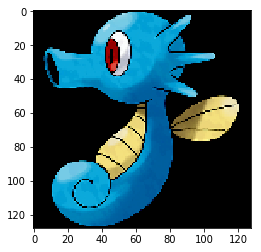

310

In [30]:
#Exemplo de imagem normalizada
plt.imshow(images[40])
plt.show()
len(images)

In [31]:
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, AveragePooling2D, Reshape, Input
from keras.layers.advanced_activations import LeakyReLU
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau

input_shape = (images[0].shape)

latent_dim = 100


# Gerador de imagens
def make_gen():
    Gen = Sequential()

    Gen.add(Dense(256, input_dim=latent_dim))
    Gen.add(LeakyReLU(alpha=0.2))
    Gen.add(BatchNormalization(momentum=0.8))
    Gen.add(Dense(512))
    Gen.add(LeakyReLU(alpha=0.2))
    Gen.add(BatchNormalization(momentum=0.8))
    Gen.add(Dense(1024))
    Gen.add(LeakyReLU(alpha=0.2))
    Gen.add(BatchNormalization(momentum=0.8))
    Gen.add(Dense(np.prod(input_shape), activation='tanh'))
    Gen.add(Reshape(input_shape))

    Gen.summary()
    
    noise = Input(shape=(latent_dim,))
    img = Gen(noise)
    
    return Model(noise, img)
    
# Discriminador
def make_discr():
    Discr = Sequential()

    Discr.add(Conv2D(128, (3, 3), strides=(2, 2), input_shape=input_shape))
    Discr.add(LeakyReLU(alpha=0.2))
    Discr.add(AveragePooling2D(pool_size = (4, 4)))
    Discr.add(Flatten())
    Discr.add(Dense(units=512, activation='relu'))
    Discr.add(Dense(units=1, activation='sigmoid'))
    Discr.summary()
    
    img = Input(shape=input_shape)
    validity = Discr(img)
    
    return Model(img, validity)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 63, 63, 128)       3584      
_________________________________________________________________
leaky_re_lu_14 (LeakyReLU)   (None, 63, 63, 128)       0         
_________________________________________________________________
average_pooling2d_4 (Average (None, 15, 15, 128)       0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 28800)             0         
_________________________________________________________________
dense_18 (Dense)             (None, 512)               14746112  
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 513       
Total params: 14,750,209
Trainable params: 14,750,209
Non-trainable params: 0
________________________________________________________________

C:\Users\rafae\Anaconda3\lib\site-packages\keras\engine\training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [Discriminador loss: 0.739667, acc.: 23.83%] [Gerador loss: 0.312281]


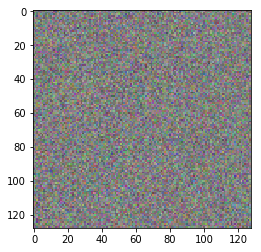

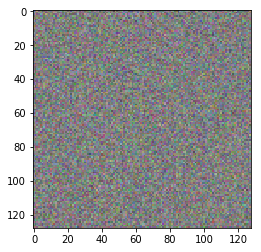

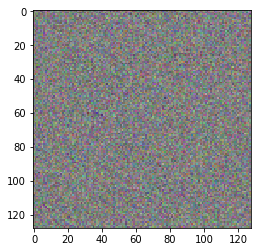

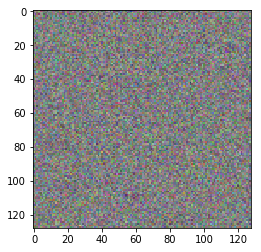

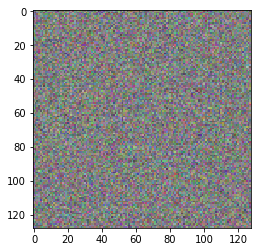

5000 [Discriminador loss: 0.212489, acc.: 94.53%] [Gerador loss: 3.663651]


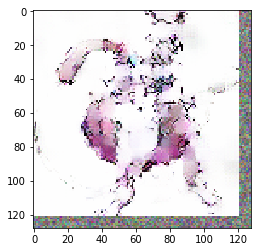

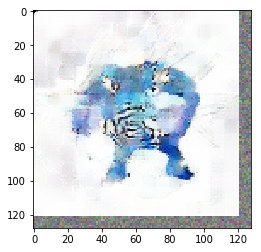

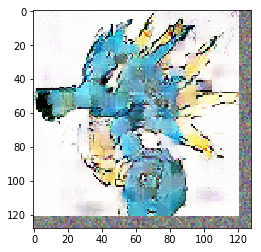

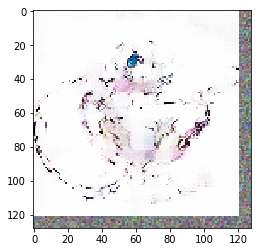

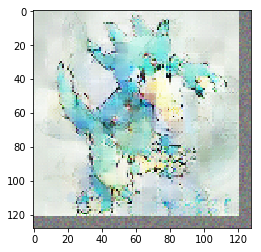

10000 [Discriminador loss: 0.081997, acc.: 98.05%] [Gerador loss: 4.268088]


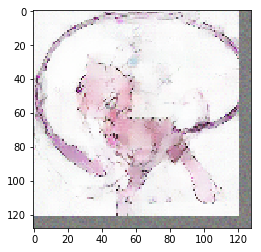

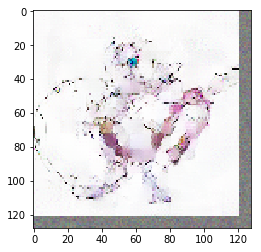

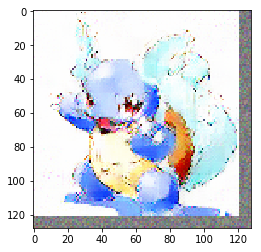

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


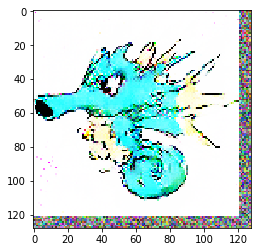

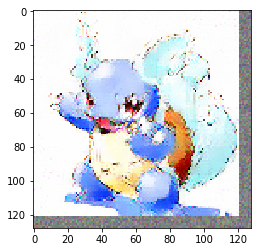

In [ ]:
optimizer = Adam(0.0002, 0.5)

Discr = make_discr()
Discr.compile(loss='binary_crossentropy',
             optimizer=optimizer,
             metrics=['accuracy'])

Gen = make_gen()

z = Input(shape=(latent_dim,))
img = Gen(z)

Discr.trainable = False

validity = Discr(img)

Combined = Model(z, validity)
Combined.compile(loss='binary_crossentropy', optimizer=optimizer)

batch_size = 128

epochs = 50000

sample_interval = 5000

valid = np.ones((batch_size, 1))
fake = np.zeros((batch_size, 1))

def sample_big_images(epoch):
    noise = np.random.normal(0, 1, (5, latent_dim))
    
    gen_imgs = Gen.predict(noise)
    
    gen_imgs = 0.5 * gen_imgs + 0.5
    
    # Mostra 3 imagens
    for i in range(5):
        plt.imshow(gen_imgs[i, :, :, :])
        plt.show()


for epoch in range(epochs):
    idx = np.random.randint(0, len(images), batch_size)
    imgs = np.array([images[j] for j in idx])
    
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    
    gen_imgs = Gen.predict(noise)
    
    d_loss_real = Discr.train_on_batch(imgs, valid)
    d_loss_fake = Discr.train_on_batch(gen_imgs, fake)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
    
    noise = np.random.normal(0, 1, (batch_size, latent_dim))

    g_loss = Combined.train_on_batch(noise, valid)
    
    if epoch % sample_interval == 0:
        print("%d [Discriminador loss: %f, acc.: %.2f%%] [Gerador loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
        sample_big_images(epoch)
    